In [1]:
import numpy as np
from matplotlib.image import NonUniformImage
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import os
import ptc_track.particles_trajectory_generator as ptg
import importlib as il
import data.bunch_configuration as buc
import ptc_track.madx_configuration as mc
import visualization.visualize as visualize
import ptc_track.matrix_indexes as matrix_indexes_madx
il.reload(ptg)
sns.set(style="whitegrid")
home = "/eos/user/r/rmucha/SWAN_projects"
name_of_folder_with_configuration = "2017_matched"
name_of_xml_file = "configuration_reco_beam1.xml"
path_to_configuration = os.path.join(home, name_of_folder_with_configuration)
path_to_xml_file = os.path.join(home, name_of_folder_with_configuration, name_of_xml_file)
item_number = 0
madx_configuration = mc.TrackConfiguration(path_to_xml_file, item_number, path_to_configuration)

In [2]:
# Parameters of bunch
x_mean = 0.0
sigma_x = 0
theta_x_mean = 0
sigma_theta_x = 0.00000
y_mean = 0
sigma_y = 0
theta_y_mean = 0.00
sigma_theta_y = 0.00000
pt_mean = -0.15
sigma_pt = 0.2

particles_number = 900

In [3]:
bunch_configuration = buc.BunchConfiguration.from_sigma(x_mean, sigma_x, particles_number,
                                                        theta_x_mean, sigma_theta_x, 1,
                                                        y_mean, sigma_y, 1,
                                                        theta_y_mean, sigma_theta_y, 1,
                                                        pt_mean, sigma_pt, 1)

In [4]:
output = ptg.generate_random_particles(madx_configuration, bunch_configuration, particles_number)

In [5]:
output["end"]

array([[ 1.00000000e+00,  1.00000000e+00,  3.15247236e-02, ...,
        -1.75565232e-01,  2.19550000e+02,  6.50000000e+03],
       [ 2.00000000e+00,  1.00000000e+00,  7.56828592e-02, ...,
        -3.49239798e-01,  2.19550000e+02,  6.50000000e+03],
       [ 3.00000000e+00,  1.00000000e+00,  5.23100879e-03, ...,
        -7.17069491e-03,  2.19550000e+02,  6.50000000e+03],
       ...,
       [ 8.98000000e+02,  1.00000000e+00,  3.80164979e-02, ...,
        -2.07643037e-01,  2.19550000e+02,  6.50000000e+03],
       [ 8.99000000e+02,  1.00000000e+00,  3.26602322e-02, ...,
        -1.81391398e-01,  2.19550000e+02,  6.50000000e+03],
       [ 9.00000000e+02,  1.00000000e+00,  4.01793141e-02, ...,
        -2.17703047e-01,  2.19550000e+02,  6.50000000e+03]])

In [7]:
# Names of segments, like MQXA.3R5
start_segment_name = "start"
end_segment_name = "end"

if start_segment_name != "start":
    output[start_segment_name].T[1] -= 1
    
non_filtered_input_matrix = output[start_segment_name]
output_matrix = output[end_segment_name]
indexes = output_matrix.T[0].astype(int) - 1
input_matrix = output[start_segment_name][indexes]

In [8]:
datasets = {
    "all input": (non_filtered_input_matrix, matrix_indexes_madx.ptc_track),
    "input which passed": (input_matrix, matrix_indexes_madx.ptc_track),
    "output": (output_matrix, matrix_indexes_madx.ptc_track)
}

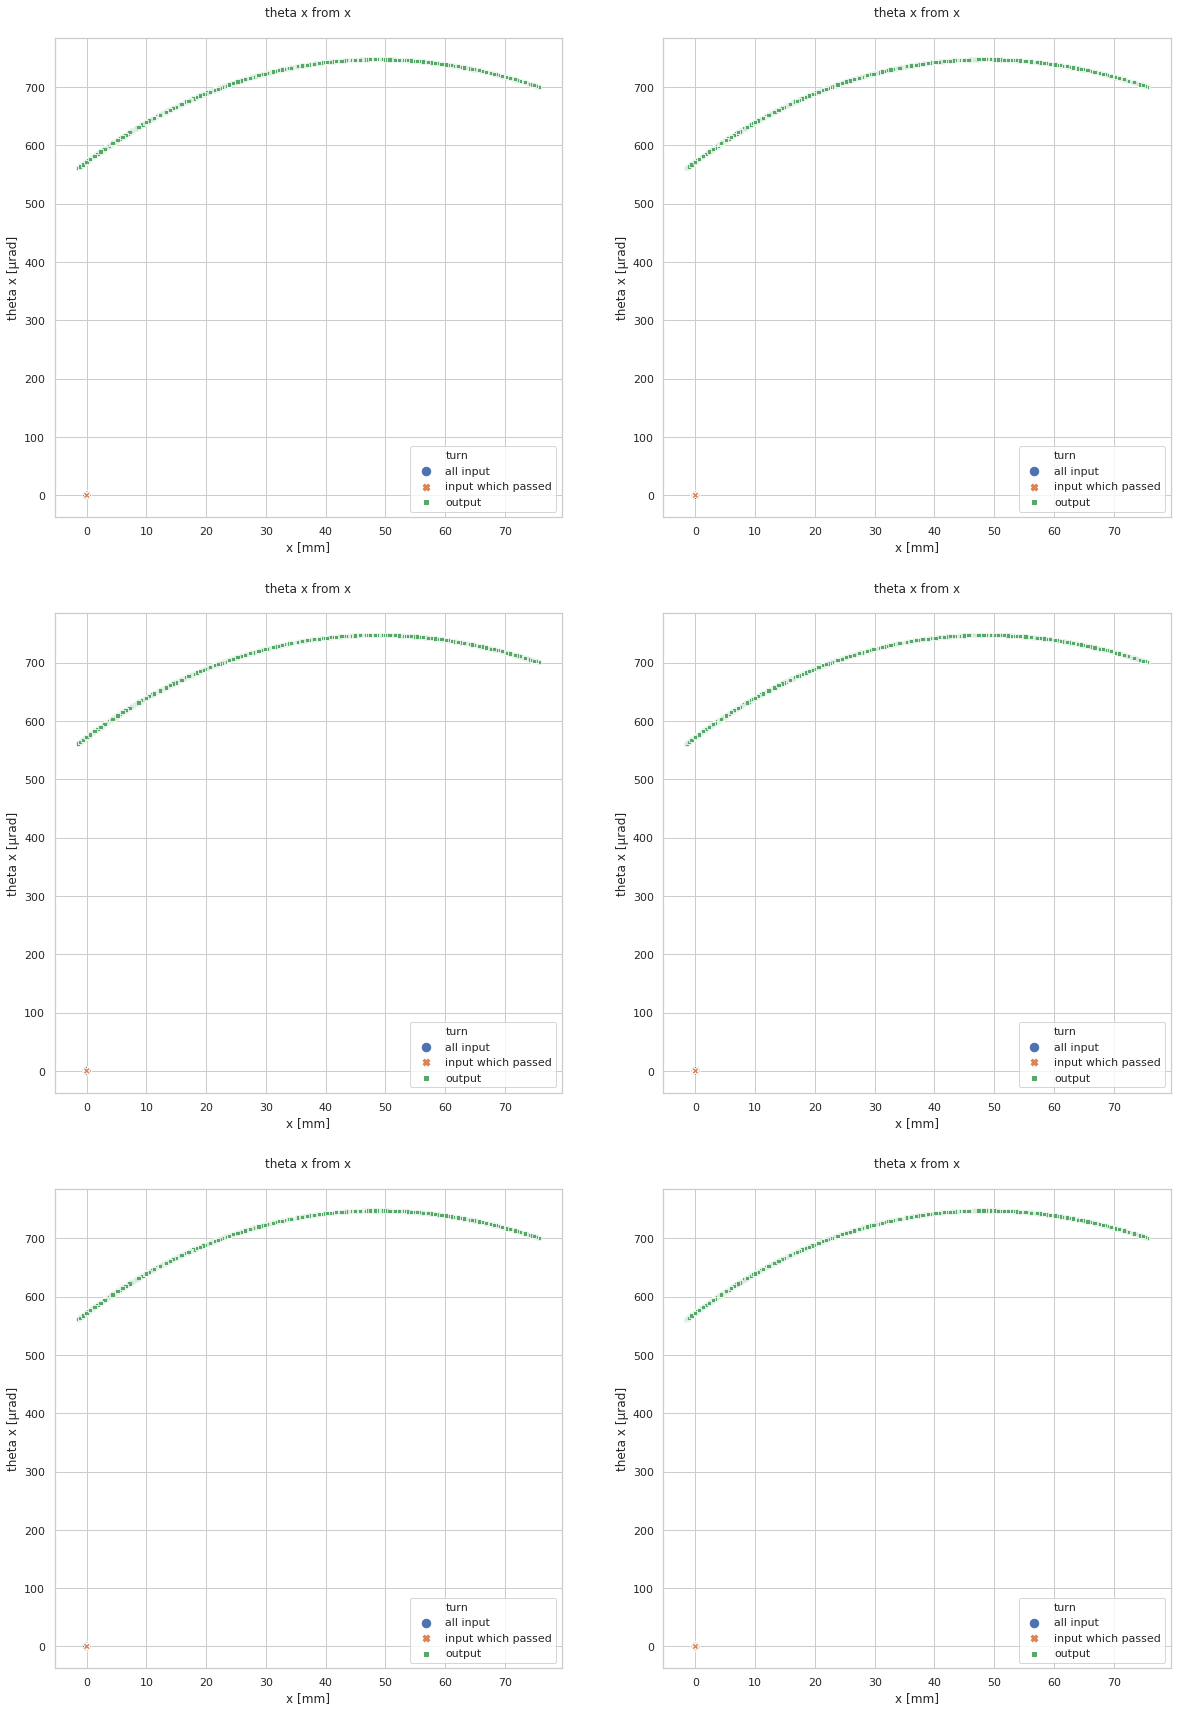

In [9]:
f, axes = plt.subplots(3, 2)

fig = plt.gcf()
fig.set_size_inches(20,30)

visualize.plot_with_turn("x", "theta x", "turn", datasets, plot_axes=axes, plot_x_pos=0, plot_y_pos=0, plot_function=sns.scatterplot)

visualize.plot_with_turn("x", "theta x", "turn", datasets, plot_axes=axes, plot_x_pos=0, plot_y_pos=1, plot_function=sns.scatterplot)

visualize.plot_with_turn("x", "theta x", "turn", datasets, plot_axes=axes, plot_x_pos=1, plot_y_pos=0, plot_function=sns.scatterplot)

visualize.plot_with_turn("x", "theta x", "turn", datasets, plot_axes=axes, plot_x_pos=1, plot_y_pos=1, plot_function=sns.scatterplot)

visualize.plot_with_turn("x", "theta x", "turn", datasets, plot_axes=axes, plot_x_pos=2, plot_y_pos=0, plot_function=sns.scatterplot)

visualize.plot_with_turn("x", "theta x", "turn", datasets, plot_axes=axes, plot_x_pos=2, plot_y_pos=1, plot_function=sns.scatterplot)


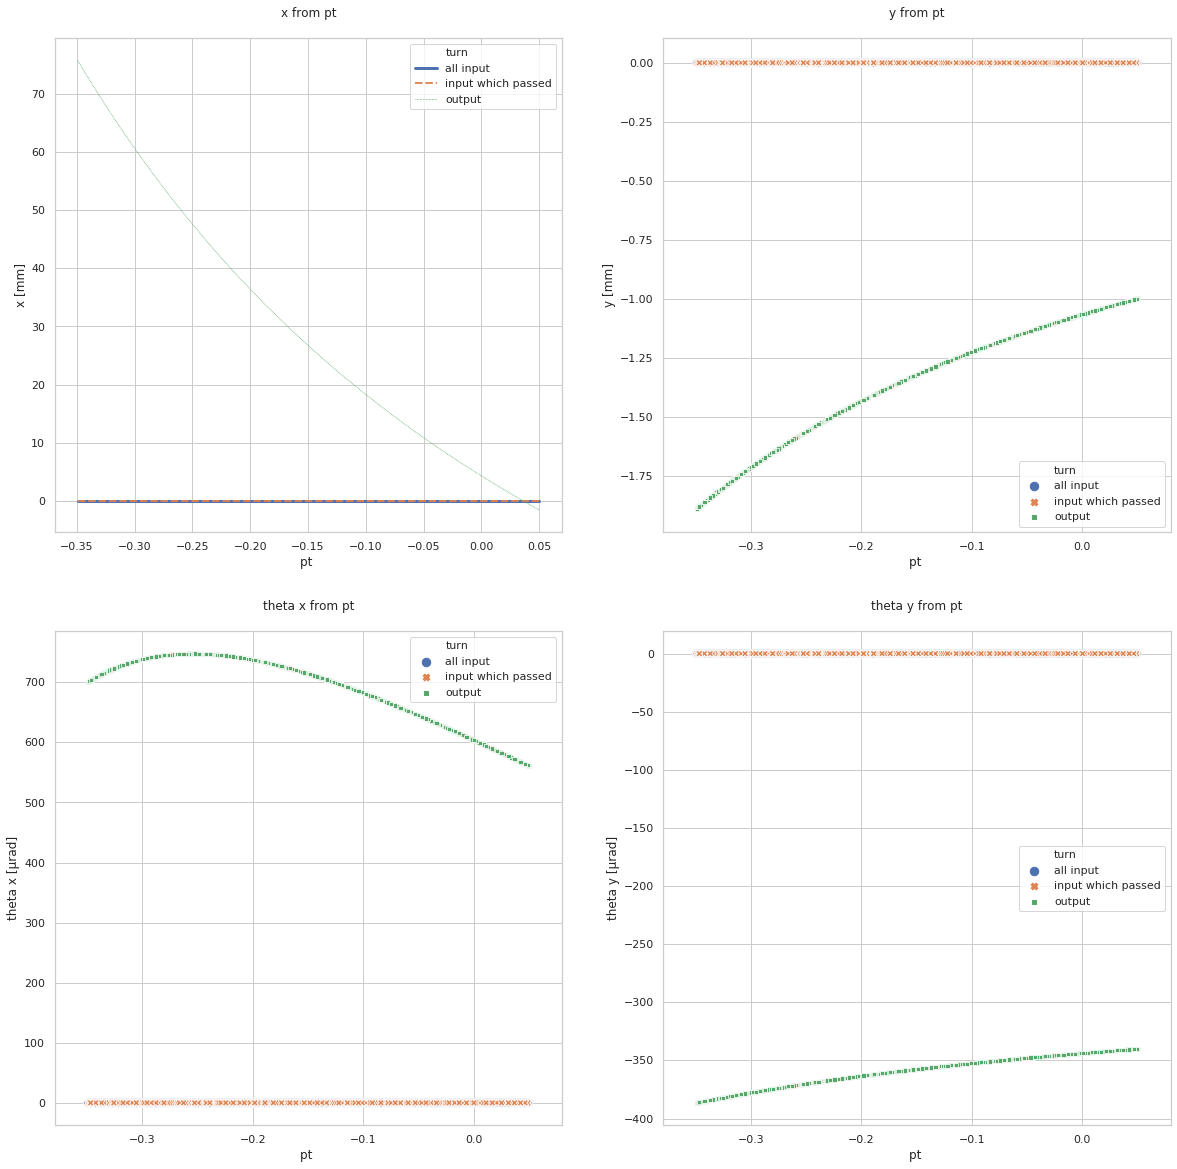

In [10]:
f, axes = plt.subplots(2, 2)

fig = plt.gcf()
fig.set_size_inches(20,20)

visualize.plot_with_turn("pt", "x", "turn", datasets, plot_axes=axes, plot_x_pos=0, plot_y_pos=0)

visualize.plot_with_turn("pt", "y", "turn", datasets, plot_axes=axes, plot_x_pos=0, plot_y_pos=1, plot_function=sns.scatterplot)

visualize.plot_with_turn("pt", "theta x", "turn", datasets, plot_axes=axes, plot_x_pos=1, plot_y_pos=0, plot_function=sns.scatterplot)

visualize.plot_with_turn("pt", "theta y", "turn", datasets, plot_axes=axes, plot_x_pos=1, plot_y_pos=1, plot_function=sns.scatterplot)

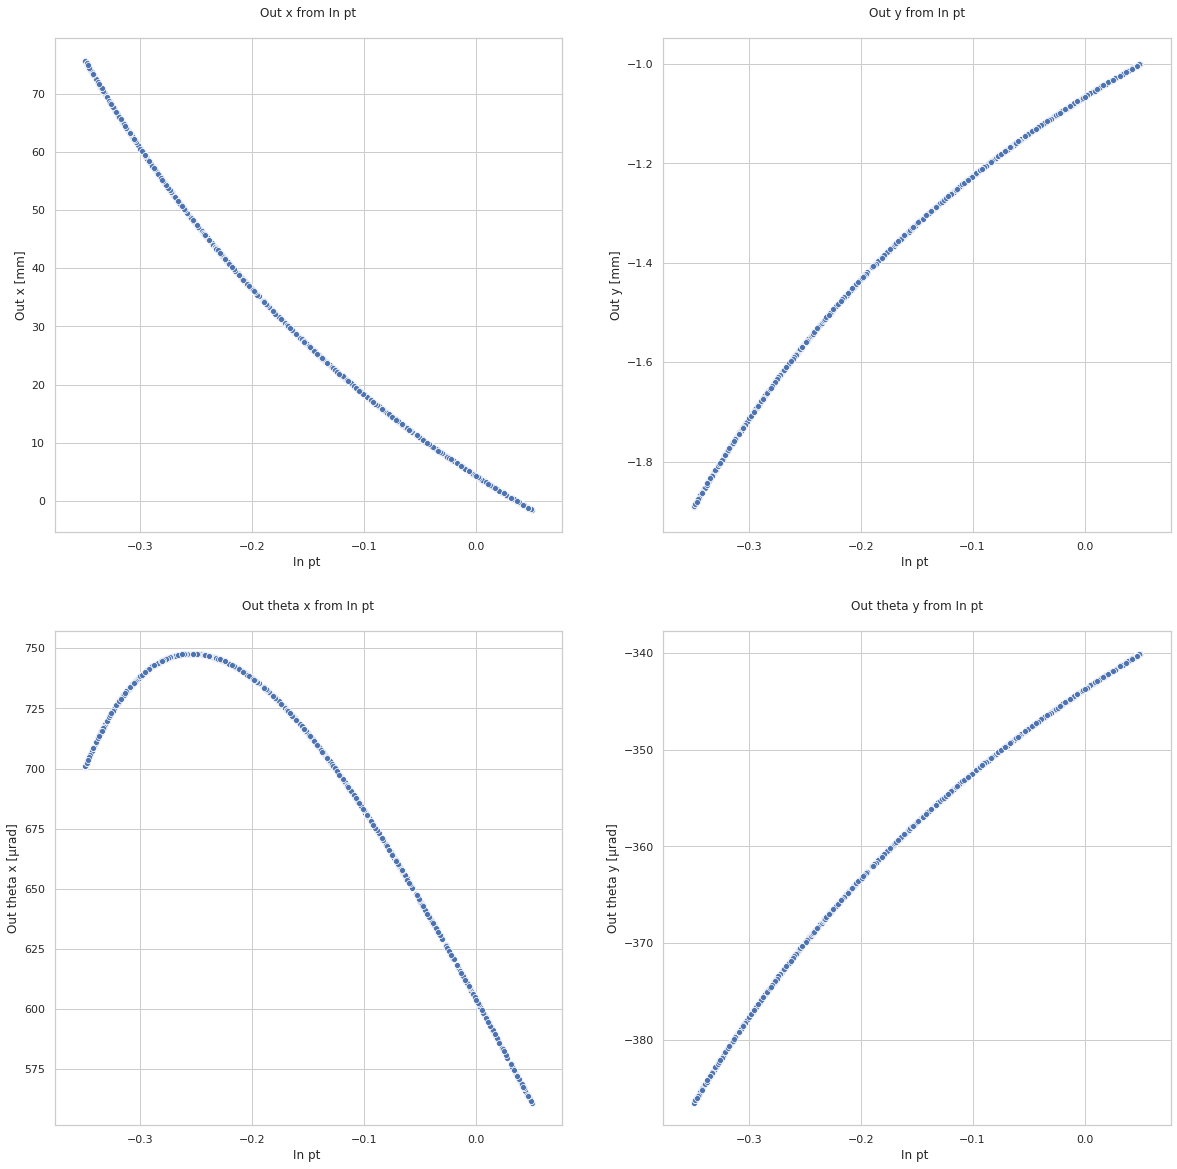

In [11]:
f, axes = plt.subplots(2, 2)

fig = plt.gcf()
fig.set_size_inches(20,20)

visualize.plot_from_two_matrices("pt", "x", input_matrix, output_matrix, matrix_indexes_madx.ptc_track, matrix_indexes_madx.ptc_track, axes, 0, 0, x_name_prefix="In ", y_name_prefix="Out ", plot_function=sns.scatterplot)

visualize.plot_from_two_matrices("pt", "y", input_matrix, output_matrix, matrix_indexes_madx.ptc_track, matrix_indexes_madx.ptc_track, axes, 0, 1, x_name_prefix="In ", y_name_prefix="Out ", plot_function=sns.scatterplot)

visualize.plot_from_two_matrices("pt", "theta x", input_matrix, output_matrix, matrix_indexes_madx.ptc_track, matrix_indexes_madx.ptc_track, axes, 1, 0, x_name_prefix="In ", y_name_prefix="Out ", plot_function=sns.scatterplot)

visualize.plot_from_two_matrices("pt", "theta y", input_matrix, output_matrix, matrix_indexes_madx.ptc_track, matrix_indexes_madx.ptc_track, axes, 1, 1, x_name_prefix="In ", y_name_prefix="Out ", plot_function=sns.scatterplot)